<a href="https://colab.research.google.com/github/Doris-QZ/Histopathologic_Cancer_Detection/blob/main/Histopathologic_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this Kaggle competition, [Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview), my goal is to build a Convolutional Neuro Network (CNN) model to identify metastatic cancer in histopathologic scans of lymph node sections.

The 'train' folder contains over 220,000 small pathology images, each named with a unique image ID. The 'train_label.csv' file provides the corresponding id and label for each image. A positive label indicates that the central 32×32 px region of a patch contains at least one pixel of tumor tissue.

**Data Source:** Will Cukierski. Histopathologic Cancer Detection. https://kaggle.com/competitions/histopathologic-cancer-detection, 2018. Kaggle.

**Connect to Kaggle and download the dataset**

In [ ]:
# Install Kaggle library
!pip install kaggle

In [ ]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Make a directory for kaggle
! mkdir ~/.kaggle

# Copy kaggle API to the directory
! cp /content/drive/MyDrive/ColabNotebooks/Kaggle_API_Key/kaggle.json ~/.kaggle/

# Change the file permissions to read/write to the owner only
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the competition dataset
! kaggle competitions download histopathologic-cancer-detection

100% 6.30G/6.31G [01:18<00:00, 17.9MB/s]
100% 6.31G/6.31G [01:18<00:00, 86.2MB/s]


In [ ]:
# Unzip the data
! unzip histopathologic-cancer-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d

In [ ]:
# Import Packages for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import seaborn as sns
import cv2 as cv
import os

# Modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Multiply, Concatenate, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.saving import register_keras_serializable
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

In [ ]:
# Continue training after runtime disconnected----need to be removed!!!
train_labels = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/HCD_train_labels.csv')
train_labels['label'] = train_labels['label'].astype(str)
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219897 entries, 0 to 219896
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        219897 non-null  object
 1   label     219897 non-null  object
 2   img_path  219897 non-null  object
dtypes: object(3)
memory usage: 5.0+ MB


# Exploratory Data Analysis (EDA)

I will perform exploratory data analysis, which includes inspecting, cleaning, and visualizing the data. Data preprocessing will be handled in the modeling section using `ImageDataGenerator` from `keras` while building the model.

In [ ]:
# Load the training set
train_labels = pd.read_csv('/content/train_labels.csv')

# Take a look at the data
print(train_labels.info())
train_labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


There are 220025 entries with 2 attributes, `id` and `label`, in the training set.



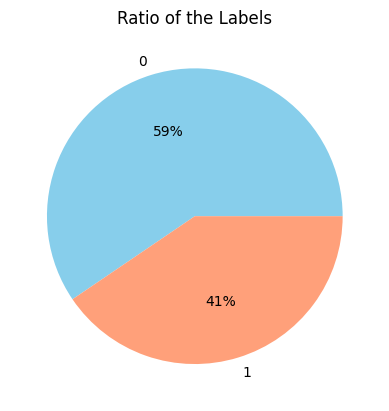

In [ ]:
# Check if the label is balanced
labels = train_labels['label'].value_counts().index
values = train_labels['label'].value_counts().values

plt.pie(values, labels = labels, colors = ['skyblue', 'lightsalmon'], autopct = '%1.0f%%')
plt.title('Ratio of the Labels');

The dataset is slightly imbalanced with 59% of class 0 and 41% of class 1. I will use 'class_weight' parameter to address this during training.

In [ ]:
# Add a column of 'img_path' to the dataset
train_labels['id'] = train_labels['id'] + '.tif'
train_path = '/content/train'
train_labels['img_path'] = train_labels['id'].apply(lambda x: os.path.join(train_path, x))
train_labels.head()

,id,label,img_path
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0,/content/train/f38a6374c348f90b587e046aac60799...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1,/content/train/c18f2d887b7ae4f6742ee445113fa1a...
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0,/content/train/755db6279dae599ebb4d39a9123cce4...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0,/content/train/bc3f0c64fb968ff4a8bd33af6971eca...
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0,/content/train/068aba587a4950175d04c680d38943f...


I'll convert the type of the 'label' to string as when we set class_mode="binary" in ImageDataGenerator.flow_from_dataframe(), it requires the type of label to be string

In [ ]:
# Change data type of 'label'
train_labels['label'] = train_labels['label'].astype(str)

I will random sampling a few images from each categories and then check the size of them.

In [ ]:
# Sample 6 images from each categories
sample_img = pd.concat([train_labels[train_labels.label == '0'].sample(6),
                        train_labels[train_labels.label == '1'].sample(6)])

for i in range(12):
  img = mpimg.imread(sample_img.iloc[i]['img_path'])
  print('Size:', img.shape, 'Max:', np.max(img), 'Min:', np.min(img))


Size: (96, 96, 3) Max: 255 Min: 0
Size: (96, 96, 3) Max: 255 Min: 1
Size: (96, 96, 3) Max: 255 Min: 2
Size: (96, 96, 3) Max: 255 Min: 0
Size: (96, 96, 3) Max: 255 Min: 0
Size: (96, 96, 3) Max: 255 Min: 5
Size: (96, 96, 3) Max: 255 Min: 0
Size: (96, 96, 3) Max: 255 Min: 0
Size: (96, 96, 3) Max: 255 Min: 0
Size: (96, 96, 3) Max: 255 Min: 0
Size: (96, 96, 3) Max: 255 Min: 0
Size: (96, 96, 3) Max: 255 Min: 5


The size of the image is 96×96, with 3 channels (RGB), and the value range between 0 and 255. Now let's take a look at the images.

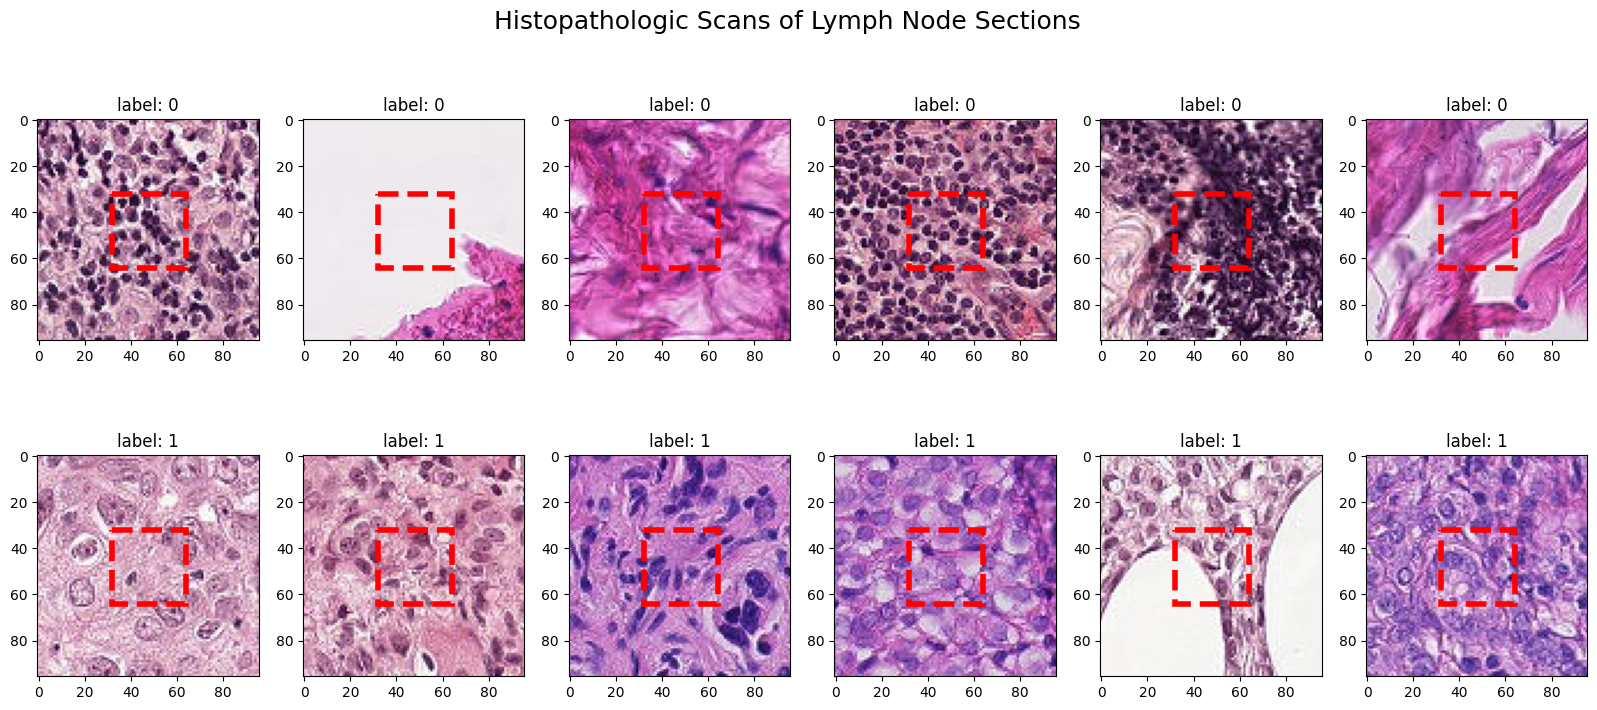

In [ ]:
# Plot images
fig, axes = plt.subplots(2, 6, figsize = (20, 8))
fig.suptitle('Histopathologic Scans of Lymph Node Sections', fontsize = 18)

for i, ax in enumerate(axes.flat):
  label = sample_img.iloc[i]['label']
  img = mpimg.imread(sample_img.iloc[i]['img_path'])
  ax.imshow(img)

  # Add a rectangle patch to the center of the image
  color = 'green' if label == 0 else 'red'
  rec = patches.Rectangle((32, 32), 32, 32, edgecolor = color, facecolor = 'none', linestyle = '--', linewidth = 4)
  ax.add_patch(rec)
  ax.set_title(f'label: {label}')


The images of the histopathologic scans with the center 32x32 region marked are shown above. The images with a green rectangular box are labeled 0, indicating benign, while the images with a red rectangular box are labeled 1, indicating malignant. Honestly, as someone with no medical background, I truly cannot tell the difference. Let's check the histogram of the RGB channels to see if we can find anything.

Since only the center 32x32 region matters, tumor tissue in the outer region of the patch does not influence the label. Therefore, I will only plot the RGB channels of the 32x32 region.

In [ ]:
# Sample 1000 images from each category
ben1000 = train_labels[train_labels['label'] == '0'].sample(1000, random_state = 12)
mal1000 = train_labels[train_labels['label'] == '1'].sample(1000, random_state = 12)

# Crop images and save it as two lists of images
ben_img = []
for i in range(1000):
  img = cv.imread(ben1000.iloc[i]['img_path'])
  cropped_img = img[32:64, 32:64]
  ben_img.append(cropped_img)

mal_img = []
for i in range(1000):
  img = cv.imread(mal1000.iloc[i]['img_path'])
  cropped_img = img[32:64, 32:64]
  mal_img.append(cropped_img)


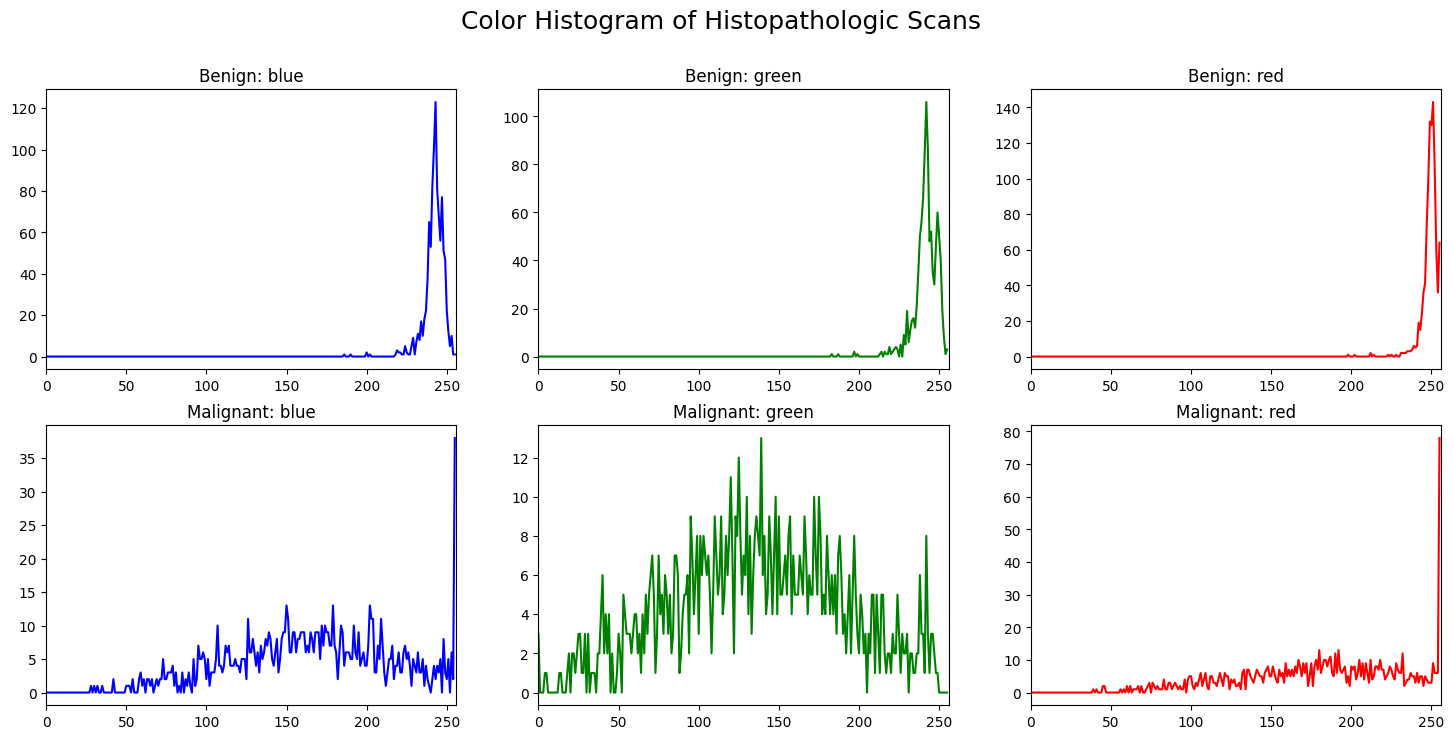

In [ ]:
# Plot color histogram
fig, axes = plt.subplots(2, 3, figsize = (18, 8))
fig.suptitle('Color Histogram of Histopathologic Scans', fontsize = 18)

colors = ['blue', 'green', 'red']
for i, col in enumerate(colors):
  hist_ben = cv.calcHist(ben_img, [i], None, [256], [0, 256])
  axes[0, i].plot(hist_ben, color = col)
  axes[0, i].set_xlim([0, 256])
  axes[0, i].set_title(f'Benign: {col}')

  hist_mal = cv.calcHist(mal_img, [i], None, [256], [0, 256])
  axes[1, i].plot(hist_mal, color = col)
  axes[1, i].set_xlim([0, 256])
  axes[1, i].set_title(f'Malignant: {col}')

plt.show()


I sampled 1,000 images from each label and plotted the density of each color channel multiple times. There are differences between the two categories, but the density plot varies with each sampling. In this sample, where the random state is set to 12, the color values of malignant images appear more centralized around the middle range, especially for the green channel, which resembles a bell-shaped distribution. In contrast, the color values of benign images tend to be larger.

Next, I will check for any low-quality images. By 'low-quality,' I mean images that are almost entirely black or white, where the grayscale values are close to 0 or 255. There is no standard for determining whether an image is too dark or too bright, so I'll plot a histogram of the grayscale images to identify reasonable cutoff values.

In [ ]:
# Read images into grayscale
img_gray_mean = []
for i in range(train_labels.shape[0]):
  img = cv.imread(train_labels.iloc[i]['img_path'], cv.IMREAD_GRAYSCALE)
  img_gray_mean.append(np.mean(img))

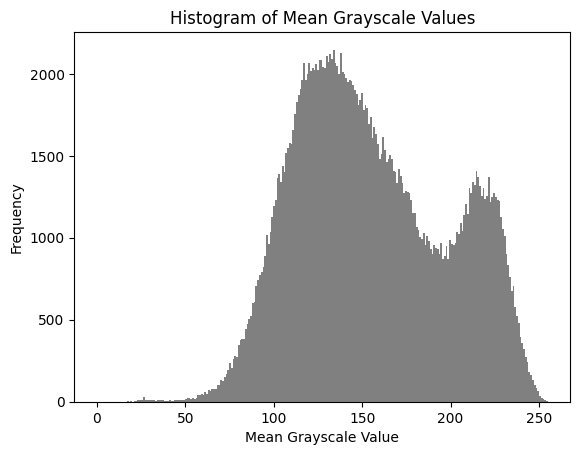

In [ ]:
# Plot the historgram of the mean grayscale values
plt.hist(img_gray_mean, bins = 256, color = 'gray')
plt.xlabel('Mean Grayscale Value')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Grayscale Values');


Most mean grayscale values are between 50 and 250, with some between 25 and 50, but very few below 25 or above 250. I will set the threshold to below 25 or above 250.

In [ ]:
# Get the index of too dark or too bright
dark_idx = [i for i, val in enumerate(img_gray_mean) if val < 25]
bright_idx = [i for i, val in enumerate(img_gray_mean) if val > 250]
print('Number of too dark images:', len(dark_idx))
print('Number of too bright images:', len(bright_idx))

Number of too dark images: 40
Number of too bright images: 88


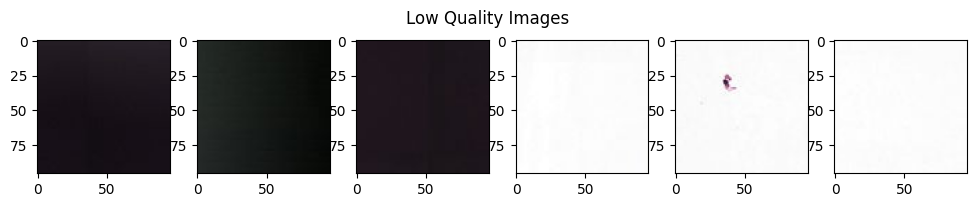

In [ ]:
# Plot a few low quality images
fig, axes = plt.subplots(1, 6, figsize = (12, 2))
fig.suptitle('Low Quality Images', fontsize = 12)
for i, idx in enumerate(dark_idx[0:3] + bright_idx[0:3]):
  img = mpimg.imread(train_labels.iloc[idx]['img_path'])
  axes[i].imshow(img)
plt.show()

As we can see, the low-quality images are either completely dark or almost entirely white. These are considered outliers, so I will remove them from `train_labels`.

In [ ]:
# Remove low quality images from the train_labels dataset
train_labels = train_labels.drop(dark_idx + bright_idx)

In [ ]:
# Save train_labels
train_labels.to_csv('/content/drive/MyDrive/ColabNotebooks/HCD_train_labels.csv', index = False)

**EDA Summary**

Here is what I did during EDA:

* Checked the ratio of each label and found that the data is slightly imbalanced, with 59% labeled as 0 and 41% labeled as 1.
* Examined the image size (96 × 96 × 3) and value range (0–255).
* Reviewed images from each category; unfortunately, I couldn't distinguish between them without a medical background.
* Explored the color histograms of images from each category and observed that the value ranges for the three channels vary between the two categories.
* Removed low-quality images based on thresholds determined by the histogram of mean grayscale values.


# Modeling

I will use Convolutional Neural Networks (CNNs), which are known for their effectiveness in classifying, manipulating, and generating images.

For evaluation, accuracy will be used as the metric during training since it is more intuitive. However, when comparing different models, I will use `classification_report`, which includes key classification metrics such as precision, recall, and F1-score, to gain a more comprehensive understanding of model performance—especially given that the dataset is slightly imbalanced.

In [ ]:
# Split the dataset into training set and validation set
train_set, valid_set = train_test_split(train_labels, test_size = 0.2, stratify = train_labels['label'], random_state = 42)

print('Training set shape:', train_set.shape)
print('Validation set shape:', valid_set.shape)

Training set shape: (175917, 3)
Validation set shape: (43980, 3)


Before training the model, I will create a data generator with augmentations. Image augmentation can improve model robustness, reduce overfitting, and lead to better generalization by applying various transformations to the original images.

**Reference:** [Image Augmentation on the fly using Keras ImageDataGenerator!](https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/)

In [ ]:
BATCH_SIZE = 64

# Create a train data generator with augmentation
train_datagen = ImageDataGenerator(rescale = 1/255,            # Normalize the pixel values to [0,1]
                                   rotation_range = 20,        # Randomly rotate images by up to 20 degree
                                   width_shift_range = 0.2,    # Horizontally shift by up to 20% of width
                                   height_shift_range = 0.2,   # Vertically shift by up to 20% of height
                                   horizontal_flip = True,     # Randomly flip images horizontally
                                   vertical_flip = True,       # Randomly flip images vertically
                                   zoom_range = 0.2           # Randomly zoom in by up to 20%
)

# Flow the train_set to the generator
train_batches = train_datagen.flow_from_dataframe(dataframe = train_set,
                                                  directory = '/content/train',     # The directory of the images
                                                  x_col = 'id',                     # Filename of the images
                                                  y_col = 'label',                  # Label of the images
                                                  class_mode = 'binary',
                                                  target_size = (96, 96),
                                                  batch_size = BATCH_SIZE,
                                                  shuffle = True,
                                                  seed = 42)


# Create a validation data generator without augumentation
valid_datagen = ImageDataGenerator(rescale = 1/255)

# Flow the valid_set to the generator
valid_batches = valid_datagen.flow_from_dataframe(dataframe = valid_set,
                                                  directory = '/content/train',
                                                  x_col = 'id',
                                                  y_col = 'label',
                                                  class_mode = 'binary',
                                                  target_size = (96, 96),
                                                  batch_size = BATCH_SIZE,
                                                  shuffle = False)

Found 175917 validated image filenames belonging to 2 classes.
Found 43980 validated image filenames belonging to 2 classes.


**First CNN model**  

I will train a CNN model with the following architecture:
1. Structure: [Conv]-[Cov-MaxPool]-[Conv]-[Cov-MaxPool]-[GAP]-[Sigmoid], with max pooling achieved using a stride of (2, 2) in the convolutional layer.
2. Filter size: 3 × 3 filters
3. Activation functions: ReLU for hidden layers, sigmoid for the output layer
4. Regularization: L2 regularization, Batch Normalization, Dropout
5. Opimization method: Adam
6. Learning rate: start from 0.0001
7. Callbacks: Model Checkpoint, Early Stopping, Reduced learning rate

The GAP(Global Average Pooling) is a pooling operation designed to replace fully connected layers in classical CNNs. It takes the average of each feature map across the spatial dimensions (height and width), which drastically reduces the spatial dimensions to 1x1, effectively converting each feature map into a single value.

Callbacks can help prevent overfitting by stopping training when a certain accuracy or loss score is reached, saving the best model encountered during training, and adjusting the learning rate over time.

**Reference**:   
* [Global Average Pooling](https://paperswithcode.com/method/global-average-pooling#:~:text=last%20mlpconv%20layer.-,Instead%20of%20adding%20fully%20connected%20layers%20on%20top%20of%20the,is%20fed%20directly%20into%20the)  
* [Essential TensorFlow and Keras Callbacks for your Neural Networks](https://kvirajdatt.medium.com/essential-tensorflow-and-keras-callbacks-for-your-neural-networks-54539244db39)

In [ ]:
# Build a CNN
cnn1 = Sequential([
    # First convolutional block
    Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', input_shape = (96, 96, 3), kernel_regularizer = l2(0.01)),
    BatchNormalization(),
    Activation('relu'),

    # Second convolutional block
    Conv2D(filters = 64, kernel_size = (3, 3), strides = (2, 2), padding = 'same', kernel_regularizer = l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    # Third convolutional block
    Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', kernel_regularizer = l2(0.01)),
    BatchNormalization(),
    Activation('relu'),

    # Fourth convolutional block
    Conv2D(filters = 256, kernel_size = (3, 3), strides = (2, 2), padding = 'same', kernel_regularizer = l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    # Use Global Average Pooling to replace Flatten and Dense layers
    GlobalAveragePooling2D(),

    # Output Layer
    Dense(1, activation = 'sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
cnn1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 96, 96, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 390,593 (1.49 MB)

 Trainable params: 389,633 (1.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Compile the CNN model with optimizer, loss function and metric
cnn1.compile(optimizer = Adam(learning_rate = 0.0001),
             loss = 'binary_crossentropy',
             metrics = ['accuracy']
)

In [ ]:
# Compute class weight
train_set_weight = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_set['label']), y = train_set['label'])
train_set_weight = dict(enumerate(train_set_weight))
print(train_set_weight)

{0: 0.8407105444257532, 1: 1.2337606777664005}


In [ ]:
# Define callbacks
model_checkpoint = ModelCheckpoint(
    filepath = '/content/drive/MyDrive/ColabNotebooks/cancer_detection_cnn1.keras',
    monitor = 'val_accuracy',
    save_best_only = True,
    mode = 'max')

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    verbose = 1,
    restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 3,
    verbose = 1,
    min_lr = 1e-6)


In [ ]:
# Using T4 GPU
history = cnn1.fit(
    train_batches,
    steps_per_epoch = len(train_batches),
    validation_data = valid_batches,
    validation_steps = len(train_batches),
    epochs = 30,
    callbacks = [model_checkpoint, early_stopping, reduce_lr],
    class_weight = train_set_weight)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 763s 273ms/step - accuracy: 0.8166 - loss: 1.5637 - val_accuracy: 0.7129 - val_loss: 0.7775 - learning_rate: 1.0000e-04
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 752s 258ms/step - accuracy: 0.8485 - loss: 0.4990 - val_accuracy: 0.8206 - val_loss: 0.4825 - learning_rate: 1.0000e-04
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 759s 276ms/step - accuracy: 0.8572 - loss: 0.4287 - val_accuracy: 0.8047 - val_loss: 0.5449 - learning_rate: 1.0000e-04
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 754s 259ms/step - accuracy: 0.8647 - loss: 0.3979 - val_accuracy: 0.6715 - val_loss: 0.9553 - learning_rate: 1.0000e-04
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8695 - loss: 0.3795
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 740s 258ms/step - accuracy: 0.8695 - loss: 0.3795 - val_accuracy: 0.7957 - val_loss: 0.5802 - learning_rate: 1.0000e-04
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━

The training log above shows that the training accuracy improves steadily, but the validation accuracy fluctuates, as does the validation loss. The validation accuracy peaks at 0.9038 in epoch 15 but later drops to 0.8525, while the training accuracy continues to increase, reaching 0.9113 in epoch 20, the last epoch before early stopping is triggered. This indicates that the model is overfitting.

**Tuning the CNN Model**  
  
I will implement the following adjustments to evaluate whether they help mitigate the overfitting problem and improve performance:
* Increase the dropout rate
* Adjust the initial learning rate
* Incorporate a Convolutional Block Attention Module (CBAM) into the model

**Reference**: [CBAM: Convolutional Block Attention Module](https://arxiv.org/abs/1807.06521)



In [ ]:
@register_keras_serializable()
# Create a custom layer 'CBAM' via subclassing
class CBAM(Layer):
  def __init__(self, ratio = 16, **kwargs):
    super(CBAM, self).__init__(**kwargs)
    self.ratio = ratio      # Reducation ratio for the channel attention module

  def build(self, input_shape):
    # Get the number of channels from the input shape
    self.channels = input_shape[-1]

    # Shared dense layers for the channel attention module
    self.dense1 = Dense(self.channels // self.ratio, activation = 'relu', use_bias = False)
    self.dense2 = Dense(self.channels, use_bias = False)

    # Conv2D layer for the spatial attention module
    self.conv = Conv2D(filters = 1, kernel_size = (7, 7), padding = 'same', activation = 'sigmoid')

    super(CBAM, self).build(input_shape)

  def channel_attention(self, x):
    # Global Max Pooling
    x1 = GlobalMaxPooling2D()(x)
    x1 = self.dense1(x1)
    x1 = self.dense2(x1)

    # Global Average Pooling
    x2 = GlobalAveragePooling2D()(x)
    x2 = self.dense1(x2)
    x2 = self.dense2(x2)

    # Add two features and apply sigmoid
    chan_atten = Activation('sigmoid')(x1 + x2)
    x = Multiply()([x, chan_atten])
    return x

  def spatial_attention(self, x):
    # Average Pooling
    x1 = tf.reduce_mean(x, axis = -1, keepdims = True)

    # Max Pooling
    x2 = tf.reduce_max(x, axis = -1, keepdims = True)

    # Concatenate two features
    spat_atten = Concatenate()([x1, x2])

    # Apply Conv2D and sigmoid
    spat_atten = self.conv(spat_atten)
    x = Multiply()([x, spat_atten])
    return x

  def call(self, x):
    # Apply channel attention module
    x = self.channel_attention(x)

    # Apply channel spatial attention module
    x = self.spatial_attention(x)
    return x

  def get_config(self):
    config = super(CBAM, self).get_config()
    config.update({'ratio': self.ratio})
    return config


In [ ]:
# Build a CNN with CBAM
cnn2 = Sequential([
    # First convolutional block
    Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', input_shape = (96, 96, 3), kernel_regularizer = l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    CBAM(),

    # Second convolutional block
    Conv2D(filters = 64, kernel_size = (3, 3), strides = (2, 2), padding = 'same', kernel_regularizer = l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),

    # Third convolutional block
    Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', kernel_regularizer = l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    CBAM(),

    # Fourth convolutional block
    Conv2D(filters = 256, kernel_size = (3, 3), strides = (2, 2), padding = 'same', kernel_regularizer = l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),

    # Use Global Max Pooling to replace Flatten and Dense layers
    GlobalAveragePooling2D(),

    # Output Layer
    Dense(1, activation = 'sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
cnn2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 96, 96, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cbam (CBAM)                          │ (None, 96, 96, 32)          │             227 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cbam_1 (CBAM)                        │ (None, 48, 48, 128)         │           2,147 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 392,967 (1.50 MB)

 Trainable params: 392,007 (1.50 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Compile the CNN model with optimizer, loss function and metric
cnn2.compile(optimizer = Adam(learning_rate = 0.0005),
             loss = 'binary_crossentropy',
             metrics = ['accuracy']
)

In [ ]:
# Define callbacks
model_checkpoint2 = ModelCheckpoint(
    filepath = '/content/drive/MyDrive/ColabNotebooks/cancer_detection_cnn2.keras',
    monitor = 'val_accuracy',
    save_best_only = True,
    mode = 'max')

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    verbose = 1,
    restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 3,
    verbose = 1,
    min_lr = 1e-6)


In [ ]:
history2 = cnn2.fit(
    train_batches,
    steps_per_epoch = len(train_batches),
    validation_data = valid_batches,
    validation_steps = len(valid_batches),
    epochs = 30,
    callbacks = [model_checkpoint2, early_stopping, reduce_lr],
    class_weight = train_set_weight)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 842s 300ms/step - accuracy: 0.8296 - loss: 0.8004 - val_accuracy: 0.5957 - val_loss: 1.5068 - learning_rate: 5.0000e-04
Epoch 2/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 730s 266ms/step - accuracy: 0.8599 - loss: 0.4027 - val_accuracy: 0.7941 - val_loss: 0.5053 - learning_rate: 5.0000e-04
Epoch 3/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 698s 254ms/step - accuracy: 0.8682 - loss: 0.3834 - val_accuracy: 0.7379 - val_loss: 0.8839 - learning_rate: 5.0000e-04
Epoch 4/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 692s 252ms/step - accuracy: 0.8711 - loss: 0.3721 - val_accuracy: 0.7739 - val_loss: 0.7715 - learning_rate: 5.0000e-04
Epoch 5/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 818s 280ms/step - accuracy: 0.8765 - loss: 0.3586 - val_accuracy: 0.8110 - val_loss: 0.4774 - learning_rate: 5.0000e-04
Epoch 6/30
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 767s 279ms/step - accuracy: 0.8779 - loss: 0.3548 - val_accuracy: 0.7921 - val_loss: 0.5214 - learning_rate: 5.0000e-04
Epoch 7/30
2749/2749 ━━━━━━━

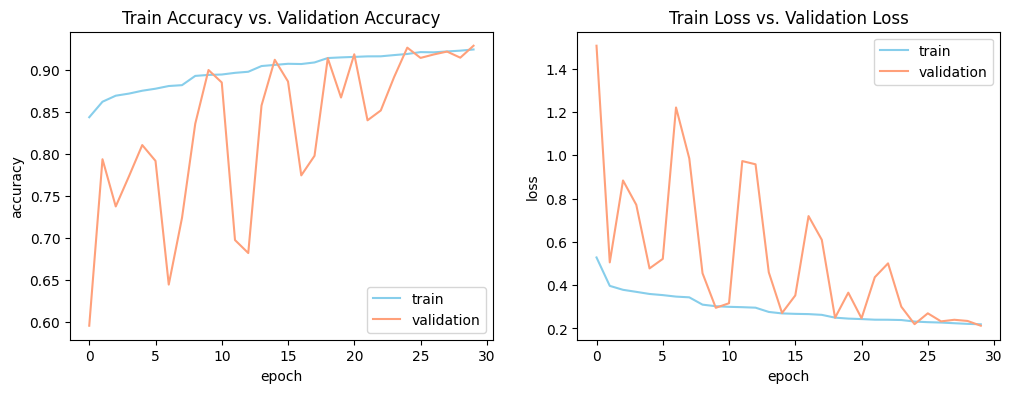

In [ ]:
# Create a dataframe of the cnn2 history
cnn2_history = pd.DataFrame({
    'dataset': ['train'] * 30 + ['validation'] * 30,
    'epoch': list(range(30)) * 2,
    'loss': history2.history['loss'] + history2.history['val_loss'],
    'accuracy': history2.history['accuracy'] + history2.history['val_accuracy']
})

# Plot the training and validation accuracy and loss
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.lineplot(data = cnn2_history, x = 'epoch', y = 'accuracy', hue = 'dataset', palette = ['skyblue', 'lightsalmon'], ax = axes[0])
axes[0].set_title('Train Accuracy vs. Validation Accuracy')
axes[0].legend(title = '');

sns.lineplot(data = cnn2_history, x = 'epoch', y = 'loss', hue = 'dataset', palette = ['skyblue', 'lightsalmon'], ax = axes[1])
axes[1].set_title('Train Loss vs. Validation Loss')
axes[1].legend(title = '');


The training log and the plot above shows the similar issue as the first CNN model: the training accuracy improves steadily, but the validation accuracy fluctuates, as does the validation loss. This indicates instability and possible overfitting of the model. However, the validation accuracy in this model is higher than that of the first model, reaching 0.9294 in epoch30, while the train accuracy is 0.9252.  

I will compare the performance of the two models using classification reports.

In [ ]:
# Compare the cnn1 and cnn2 models
pred_proba_cnn1 = cnn1.predict(valid_batches, verbose = 0)
pred_cnn1 = np.round(pred_proba_cnn1).astype(int)

pred_proba_cnn2 = cnn2.predict(valid_batches, verbose = 0)
pred_cnn2 = np.round(pred_proba_cnn2).astype(int)

y_true = valid_set['label'].astype(int)

# Print the classification reports
print('Model_1: cnn1')
print(classification_report(y_true, pred_cnn1))

print('Model_2: cnn2')
print(classification_report(y_true, pred_cnn2))


Model_1: cnn1
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     26156
           1       0.94      0.82      0.87     17824

    accuracy                           0.90     43980
   macro avg       0.91      0.89      0.90     43980
weighted avg       0.91      0.90      0.90     43980

Model_2: cnn2
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     26156
           1       0.91      0.91      0.91     17824

    accuracy                           0.93     43980
   macro avg       0.93      0.93      0.93     43980
weighted avg       0.93      0.93      0.93     43980



The second model, 'cnn2', outperforms the first model across all metrics, including the macro and weighted averages of precision, recall, F1-score, and accuracy, as shown in the classification report. Next, I will check the AUC score of the 'cnn2' model and plot the ROC curve.

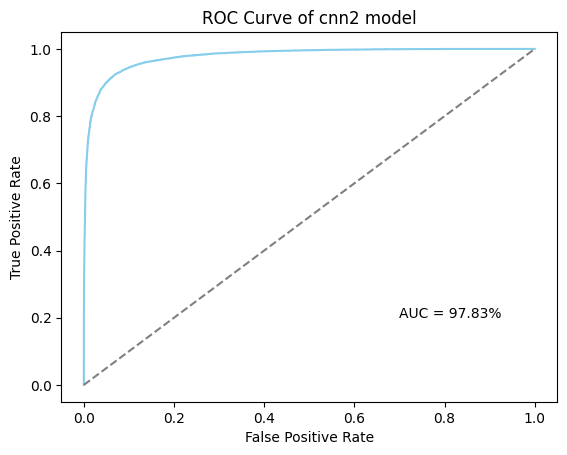

In [ ]:
# Plot ROC curve of cnn2 model
fpr, tpr, threshold = roc_curve(y_true, pred_proba_cnn2)
auc = roc_auc_score(y_true, pred_proba_cnn2)
plt.plot(fpr, tpr, color = 'skyblue', linestyle = '-')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), color = 'gray', linestyle = '--')
plt.title('ROC Curve of cnn2 model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.text(0.7, 0.2, f'AUC = {auc:.2%}', fontsize = 10);

In [ ]:
# Load the model again as the Google Colab runtime was disconnected.
# cnn2 = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/cancer_detection_cnn2.keras', custom_objects={'CBAM': CBAM})

I will use cnn2 model to make prediction on the test set, and then submit to Kaggle.

In [ ]:
# Load the sample_submission dataset
submission = pd.read_csv('/content/sample_submission.csv')

# Addd '.tif' to id
submission['filename'] = submission['id'] + '.tif'

# Drop 'label' column
submission = submission.drop('label', axis = 1)

# Create the test_batches
test_batches = ImageDataGenerator(rescale = 1/255).flow_from_dataframe(dataframe = submission,
                                                  directory = '/content/test',
                                                  x_col = 'filename',
                                                  class_mode = None,
                                                  target_size = (96, 96),
                                                  batch_size = BATCH_SIZE,
                                                  shuffle = False)

# Make the prediction on the test set
cnn2_pred_test = cnn2.predict(test_batches, verbose = 0)

# Add the prediction to the submission dataset
submission['label'] = cnn2_pred_test

# Drop 'filename' column
submission = submission.drop('filename', axis = 1)

# Save the submission
submission.to_csv('/content/drive/MyDrive/ColabNotebooks/cnn2_pred_test.csv', index = False)

Found 57458 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


After submit to Kaggle, I got the result as below:

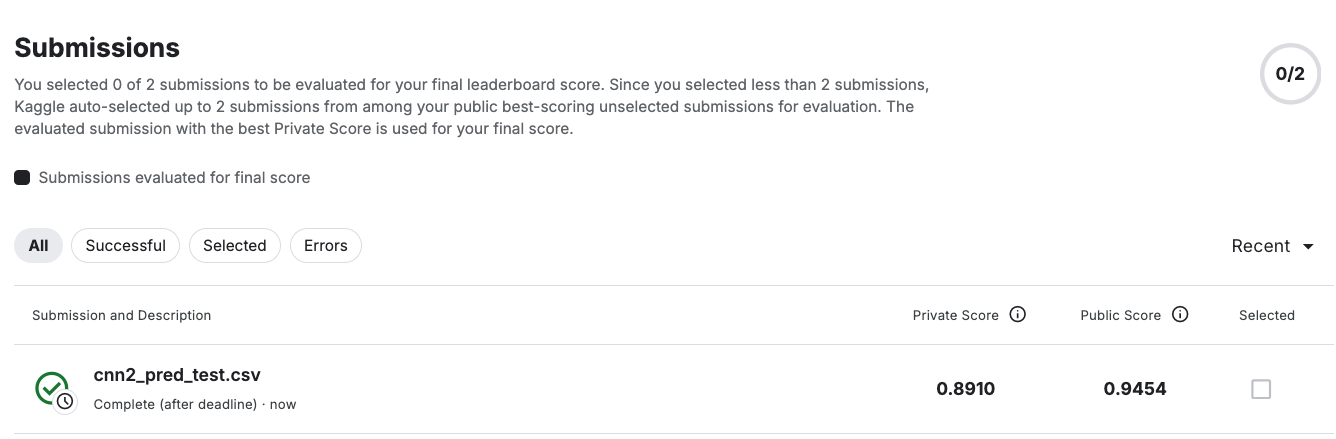

**Transfer Learning**  

Last, I will experiment with transfer learning using the pretrained 'EfficientNet B0' model, which is known for its efficiency and accuracy.

This model takes input images of shape (224, 224, 3), and the input data should be in the range [0, 255]. Normalization is included as part of the model. I will modify the data generator accordingly.

**Reference**:   
[EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)  
[Image classification via fine-tuning with EfficientNet](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/).

In [ ]:
BATCH_SIZE = 64

# Create a train data generator with augmentation
train_datagen_effB0 = ImageDataGenerator(
                                   rotation_range = 20,        # Randomly rotate images by up to 20 degree
                                   width_shift_range = 0.2,    # Horizontally shift by up to 20% of width
                                   height_shift_range = 0.2,   # Vertically shift by up to 20% of height
                                   horizontal_flip = True,     # Randomly flip images horizontally
                                   vertical_flip = True,       # Randomly flip images vertically
                                   zoom_range = 0.2           # Randomly zoom in by up to 20%
)

# Flow the train_set to the generator
train_batches_effB0 = train_datagen_effB0.flow_from_dataframe(dataframe = train_set,
                                                  directory = '/content/train',     # The directory of the images
                                                  x_col = 'id',                     # Filename of the images
                                                  y_col = 'label',                  # Label of the images
                                                  class_mode = 'binary',
                                                  target_size = (224, 224),
                                                  batch_size = BATCH_SIZE,
                                                  shuffle = True,
                                                  seed = 42)



# Flow the valid_set to the generator
valid_batches_effB0 =  ImageDataGenerator().flow_from_dataframe(dataframe = valid_set,
                                                  directory = '/content/train',
                                                  x_col = 'id',
                                                  y_col = 'label',
                                                  class_mode = 'binary',
                                                  target_size = (224, 224),
                                                  batch_size = BATCH_SIZE,
                                                  shuffle = False)

Found 175917 validated image filenames belonging to 2 classes.
Found 43980 validated image filenames belonging to 2 classes.


In [ ]:
# Download the pretrained model
eff_b0 = keras.applications.EfficientNetB0(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224, 224, 3)
)

# Freeze the model
eff_b0.trainable = False

# Create new model on top
inputs = keras.Input(shape = (224, 224, 3))
x = eff_b0(inputs, training = False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation = 'sigmoid')(x)
cnn3 = keras.Model(inputs, outputs)

cnn3.summary(show_trainable = True)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1 (InputLayer)          │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ efficientnetb0 (Functional)         │ (None, 7, 7, 1280)           │     4,049,571 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d            │ (None, 1280)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 1280)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 1)                    │         1,281 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Compile the CNN model with optimizer, loss function and metric
cnn3.compile(optimizer = Adam(),
             loss = 'binary_crossentropy',
             metrics = ['accuracy']
)

# Define callbacks
model_checkpoint3 = ModelCheckpoint(
    filepath = '/content/drive/MyDrive/ColabNotebooks/cancer_detection_cnn3.keras',
    monitor = 'val_accuracy',
    save_best_only = True,
    mode = 'max')

I'll run 5 epochs first to see how it goes.

In [ ]:
history3 = cnn3.fit(
    train_batches_effB0,
    steps_per_epoch = len(train_batches_effB0),
    validation_data = valid_batches_effB0,
    validation_steps = len(valid_batches_effB0),
    epochs = 5,
    callbacks = [model_checkpoint3, early_stopping, reduce_lr],
    class_weight = train_set_weight)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2483s 894ms/step - accuracy: 0.7839 - loss: 0.4509 - val_accuracy: 0.8123 - val_loss: 0.4116 - learning_rate: 0.0010
Epoch 2/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2330s 844ms/step - accuracy: 0.8207 - loss: 0.3994 - val_accuracy: 0.8212 - val_loss: 0.3988 - learning_rate: 0.0010
Epoch 3/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2328s 832ms/step - accuracy: 0.8225 - loss: 0.3950 - val_accuracy: 0.8186 - val_loss: 0.4004 - learning_rate: 0.0010
Epoch 4/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2404s 869ms/step - accuracy: 0.8225 - loss: 0.3962 - val_accuracy: 0.8186 - val_loss: 0.4009 - learning_rate: 0.0010
Epoch 5/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.8269 - loss: 0.3886
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2319s 843ms/step - accuracy: 0.8269 - loss: 0.3886 - val_accuracy: 0.8156 - val_loss: 0.4056 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch:

The training took a long time, about 40 minutes per epoch. The validation accuracy started at 0.8123, which is higher than that of the first two models, but it did not improve much over five epochs. I will train for another five epochs on top of this.

In [ ]:
history4 = cnn3.fit(train_batches_effB0,
    steps_per_epoch = len(train_batches_effB0),
    validation_data = valid_batches_effB0,
    validation_steps = len(valid_batches_effB0),
    epochs = 5,
    callbacks = [model_checkpoint3, early_stopping, reduce_lr],
    class_weight = train_set_weight)

Epoch 1/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2280s 829ms/step - accuracy: 0.8242 - loss: 0.3933 - val_accuracy: 0.8176 - val_loss: 0.4040 - learning_rate: 5.0000e-04
Epoch 2/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2390s 862ms/step - accuracy: 0.8258 - loss: 0.3899 - val_accuracy: 0.8224 - val_loss: 0.3971 - learning_rate: 5.0000e-04
Epoch 3/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2256s 821ms/step - accuracy: 0.8246 - loss: 0.3912 - val_accuracy: 0.8217 - val_loss: 0.3981 - learning_rate: 5.0000e-04
Epoch 4/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2298s 836ms/step - accuracy: 0.8271 - loss: 0.3884 - val_accuracy: 0.8221 - val_loss: 0.3976 - learning_rate: 5.0000e-04
Epoch 5/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2284s 831ms/step - accuracy: 0.8247 - loss: 0.3930 - val_accuracy: 0.8243 - val_loss: 0.3951 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 5.


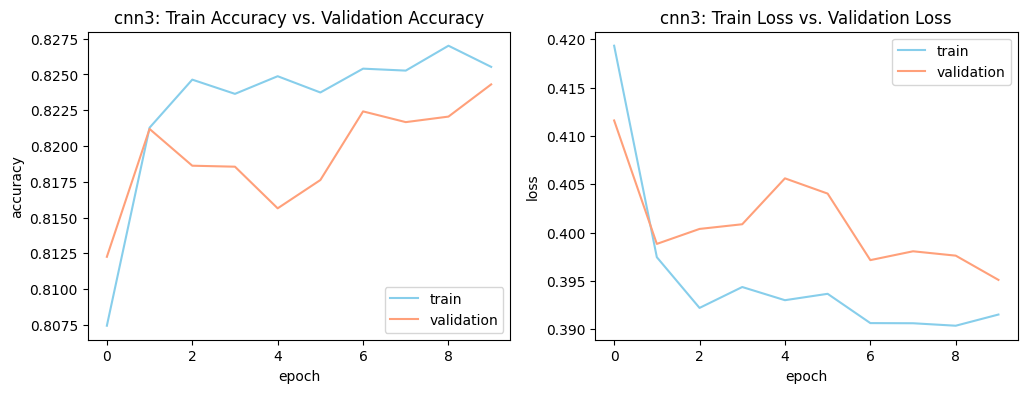

In [ ]:
# Create a dataframe of the cnn2 history
cnn3_history = pd.DataFrame({
    'dataset': ['train'] * 10 + ['validation'] * 10,
    'epoch': list(range(10)) * 2,
    'loss': history3.history['loss'] + history4.history['loss'] + history3.history['val_loss'] + history4.history['val_loss'],
    'accuracy': history3.history['accuracy'] + history4.history['accuracy']+ history3.history['val_accuracy'] + history4.history['val_accuracy']
})

# Plot the training and validation accuracy and loss
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.lineplot(data = cnn3_history, x = 'epoch', y = 'accuracy', hue = 'dataset', palette = ['skyblue', 'lightsalmon'], ax = axes[0])
axes[0].set_title('cnn3: Train Accuracy vs. Validation Accuracy')
axes[0].legend(title = '');

sns.lineplot(data = cnn3_history, x = 'epoch', y = 'loss', hue = 'dataset', palette = ['skyblue', 'lightsalmon'], ax = axes[1])
axes[1].set_title('cnn3: Train Loss vs. Validation Loss')
axes[1].legend(title = '');

The plot above shows that the validation accuracy and loss of cnn3 do not fluctuate as much as in the cnn2 model, indicating that cnn3 is more stable and less prone to overfitting. Since I only ran 10 epochs, the performance does not show much improvement.

Let's use cnn3 to predict on the test set.

In [ ]:
# Load the sample_submission dataset
submission = pd.read_csv('/content/sample_submission.csv')

# Addd '.tif' to id
submission['filename'] = submission['id'] + '.tif'

# Drop 'label' column
submission = submission.drop('label', axis = 1)

# Create the test_batches
test_batches = ImageDataGenerator().flow_from_dataframe(dataframe = submission,
                                                  directory = '/content/test',
                                                  x_col = 'filename',
                                                  class_mode = None,
                                                  target_size = (224, 224),
                                                  batch_size = BATCH_SIZE,
                                                  shuffle = False)

# Make the prediction on the test set
cnn3_pred_test = cnn3.predict(test_batches, verbose = 0)

# Add the prediction to the submission dataset
submission['label'] = cnn3_pred_test

# Drop 'filename' column
submission = submission.drop('filename', axis = 1)

# Save the submission
submission.to_csv('/content/drive/MyDrive/ColabNotebooks/cnn3_pred_test.csv', index = False)

Found 57458 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


After submitting the prediction to Kaggle, I got the result as follows:

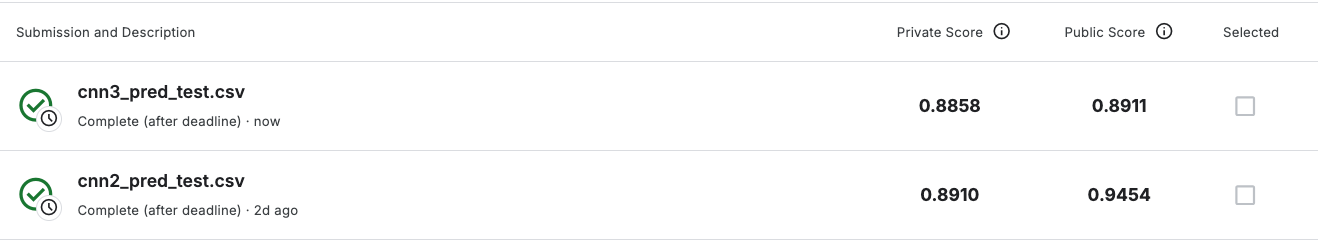

# Results and Analysis

I built two CNN models to identify metastatic cancer in histopathologic scans of lymph node sections. The second model has a similar architecture to the first but includes some parameter adjustments, such as a higher dropout rate, a higher learning rate, and an additional Convolutional Block Attention Module.  

The classification reports show that the second model, 'cnn2,' outperforms the first across all metrics, including the macro and weighted averages of precision, recall, F1-score, and accuracy, all of which are 0.93. The ROC curve of the cnn2 model is close to the upper left corner, with an AUC score of 0.9783.   

However, the training log and history plot of cnn2 show that while the training accuracy improves steadily, the validation accuracy and validation loss fluctuate. This suggests instability and potential overfitting.
Although I included regularization techniques (L2 regularization, Batch Normalization, Dropout) and data augmentation (randomly rotating, shifting, flipping, or zooming the images), the overfitting problem does not seem to be eliminated. I also read other notebooks on Kaggle, and it seems that reducing the number of layers doesn’t help either.  

I experimented with transfer learning using the pretrained EfficientNet B0 model, hoping it would show significantly better performance.The validation accuracy of this model (cnn3) started at 0.8123, which is higher than that of the first two models. The history plot shows that both validation accuracy and loss fluctuate less than in the cnn2 model, indicating that CNN3 is more stable and less prone to overfitting. However, the performance does not improve much over 10 epochs, and training takes significantly longer--about 40 minutes per epoch on a T4 GPU. Even though I froze the weights in the EfficientNet B0 model, the number of trainable parameters is only 1,281, limited to the last two layers.   

After submitting the predictions from cnn2 and cnn3 to Kaggle, I got the AUC scores (public score) as follows: 0.9454 for cnn2’s prediction, and 0.8911 for cnn3’s prediction. Apparently, transfer learning did not yield satisfactory results, but it was only trained for 10 epochs.  


# Conclusion

In this project, I built multiple CNN models to identify metastatic cancer in histopathologic scans of lymph node sections. The one with the following architecture performed the best:

1. Structure: [Conv-CBAM] - [Conv-MaxPool] - [Conv-CBAM] - [Conv-MaxPool] - [Global Average Pooling (GAP)] - [Sigmoid], with max pooling applied using a stride of (2,2).
2. Filter size: 3 × 3
3. Activation functions: ReLU for hidden layers, sigmoid for the output layer
4. Regularization: L2 regularization, Batch Normalization, Dropout (0.3 in the 2nd block, 0.4 in the 4th block)
5. Optimization method: Adam
6. Learning rate: Starting at 0.0005
7. Callbacks: ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

The model achieved 0.93 on the macro and weighted averages of precision, recall, F1-score, and accuracy. It also obtained an AUC score of 0.9783 on the validation set and 0.9454 on the Kaggle test set.

However, the model is still far from perfect, as the history plot indicates instability and potential overfitting. I’m not sure what else I can do to improve it right now, but perhaps after learning more about CNNs, I will come up with better ideas.
